Preview:


,invoice,stockcode,description,quantity,unitprice,invoicedate,country,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,2009-12-01 07:45:00,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,6.75,2009-12-01 07:45:00,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,2009-12-01 07:45:00,United Kingdom,81.0


Shape: (9797, 8)

=== KPIs (first 10k rows) ===
rows: 9,797.00
unique_invoices: 365.00
unique_products: 2,116.00
unique_customers: nan
total_revenue: 201,022.28
avg_order_value: 550.75


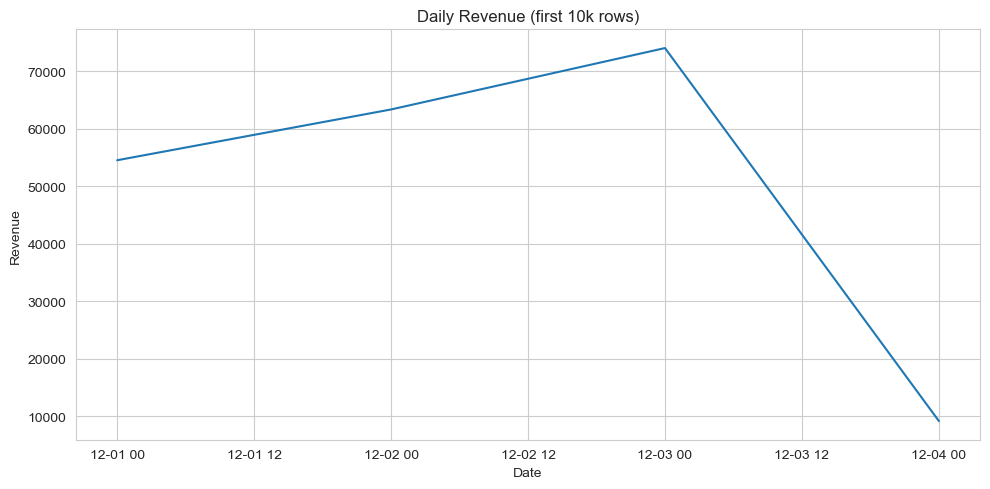

C:\Users\100884312\AppData\Local\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


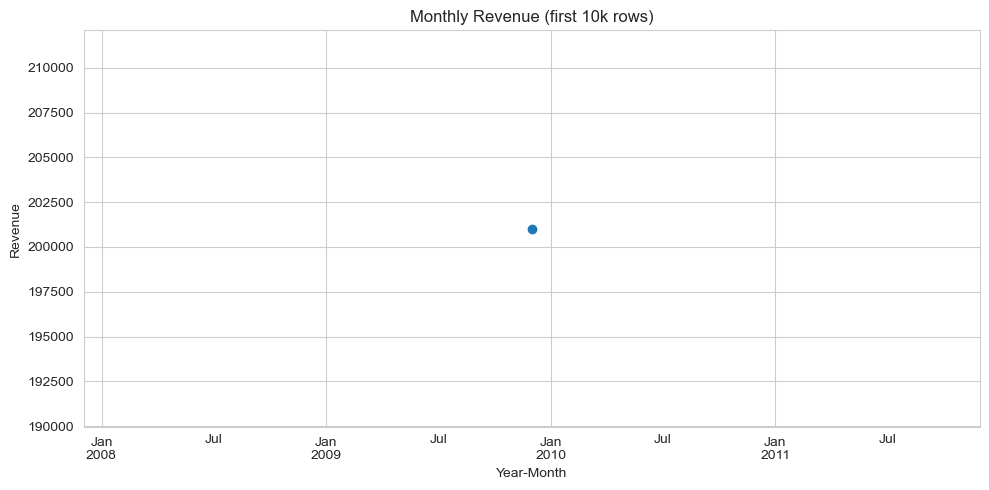


Top 10 products by revenue:


,,revenue,cum_pct,class
stockcode,description,,,
22086,PAPER CHAIN KIT 50'S CHRISTMAS,4990.21,0.024824,A
DOT,DOTCOM POSTAGE,4433.82,0.046881,A
84347,ROTATING SILVER ANGELS T-LIGHT HLDR,3991.54,0.066737,A
85123A,WHITE HANGING HEART T-LIGHT HOLDER,3697.94,0.085132,A
15056BL,EDWARDIAN PARASOL BLACK,3546.10,0.102773,A
84879,ASSORTED COLOUR BIRD ORNAMENT,2920.39,0.117300,A
20679,EDWARDIAN PARASOL RED,2686.30,0.130664,A
85014B,RED/WHITE DOTS RUFFLED UMBRELLA,2177.55,0.141496,A
15056N,EDWARDIAN PARASOL NATURAL,2139.15,0.152137,A


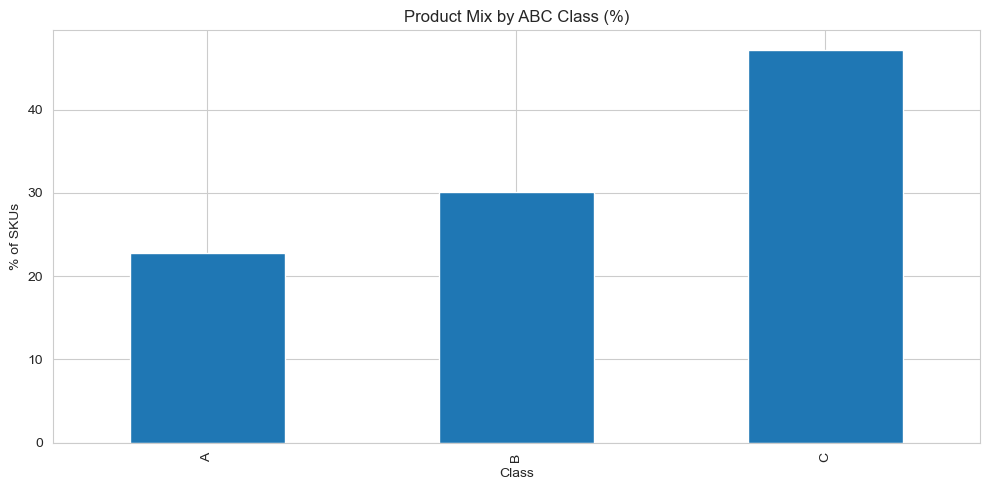

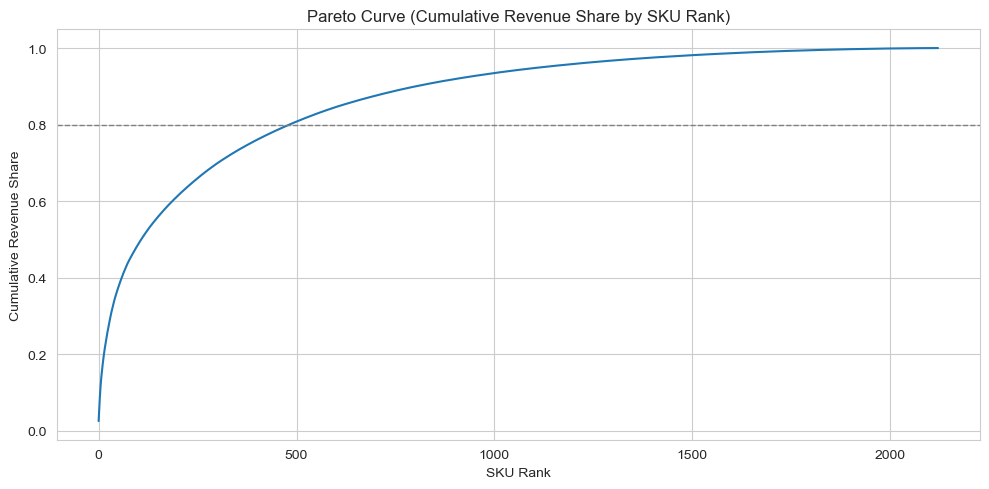

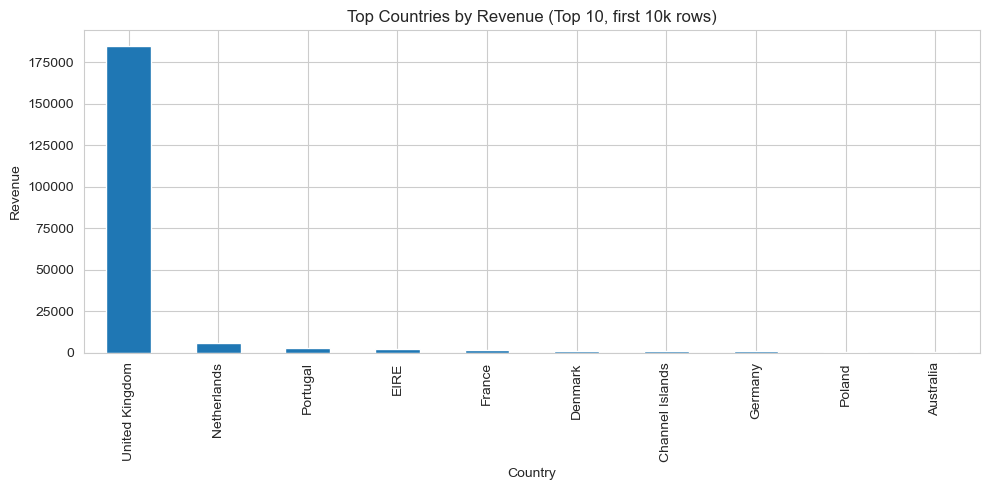


(No customerid available — skipping RFM segmentation.)
(No customerid available — skipping cohort analysis.)

=== Executive Summary (first 10k rows) ===
- Total revenue: $201,022
- Unique invoices: 365 | Unique SKUs: 2116 | Unique customers: nan
- Average order value (AOV): $550.75
- Product mix shows strong concentration; A-class SKUs dominate (Pareto).
- Top 5 SKUs by revenue:
    • [22086] PAPER CHAIN KIT 50'S CHRISTMAS                                $4,990
    • [DOT] DOTCOM POSTAGE                                                $4,434
    • [84347] ROTATING SILVER ANGELS T-LIGHT HLDR                           $3,992
    • [85123A] WHITE HANGING HEART T-LIGHT HOLDER                            $3,698
    • [15056BL] EDWARDIAN PARASOL BLACK                                       $3,546
- Strongest country by revenue: United Kingdom ($184,902)

Recommended actions:
1) Keep A-class items in stock and feature them prominently (80/20 rule).
2) Use monthly seasonality for inventory planni

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


LOCAL_CSV_PATH = r"Downloads\online_retail_II.csv"  
NROWS = 10_000  

plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False
})
sns.set_style("whitegrid")


#Loading & Cleaning

def load_transactions(local_csv: str, nrows: int = 10_000) -> pd.DataFrame:
    path = Path(local_csv)
    if not path.exists():
        raise FileNotFoundError(f"CSV not found: {path}")

    df = pd.read_csv(path, nrows=nrows, low_memory=False)

# Normalizing columns and mapping to canonical names
    df.columns = [c.strip().lower() for c in df.columns]
    rename_map = {
        "invoiceno": "invoice", "invoice_no":"invoice", "invoice":"invoice",
        "stockcode": "stockcode", "stock_code":"stockcode",
        "description":"description",
        "quantity": "quantity",
        "unitprice": "unitprice", "price":"unitprice",
        "invoicedate": "invoicedate", "invoice_date":"invoicedate",
        "customerid":"customerid", "customer_id":"customerid",
        "country":"country"
    }
    df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

  
    keep = [c for c in ["invoice","stockcode","description","quantity",
                        "unitprice","invoicedate","customerid","country"] if c in df.columns]
    df = df[keep].copy()


    if "invoicedate" in df.columns:
        df["invoicedate"] = pd.to_datetime(df["invoicedate"], errors="coerce")
        df = df.dropna(subset=["invoicedate"])

    for c in ["quantity","unitprice","customerid"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

# Removing cancellations (invoice starts with 'C'), non-positive qty/price
    if "invoice" in df.columns:
        df = df[~df["invoice"].astype(str).str.startswith("C")]
    if "quantity" in df.columns:
        df = df[df["quantity"] > 0]
    if "unitprice" in df.columns:
        df = df[df["unitprice"] > 0]

# Revenue
    if {"quantity","unitprice"}.issubset(df.columns):
        df["revenue"] = df["quantity"] * df["unitprice"]

    if "description" in df.columns:
        df["description"] = df["description"].fillna("")

    return df.reset_index(drop=True)

df = load_transactions(LOCAL_CSV_PATH, nrows=NROWS)
print("Preview:")
display(df.head(3))
print("Shape:", df.shape)


# KPIs (core business metrics)

def compute_kpis(tx: pd.DataFrame) -> dict:
    k = {}
    k["rows"] = len(tx)
    k["unique_invoices"] = tx["invoice"].nunique() if "invoice" in tx else np.nan
    k["unique_products"] = tx["stockcode"].nunique() if "stockcode" in tx else np.nan
    k["unique_customers"] = tx["customerid"].nunique() if "customerid" in tx else np.nan
    k["total_revenue"] = tx["revenue"].sum() if "revenue" in tx else np.nan
    k["avg_order_value"] = (
        tx.groupby("invoice")["revenue"].sum().mean()
        if {"invoice","revenue"}.issubset(tx.columns) else np.nan
    )
    return k

kpis = compute_kpis(df)
print("\n=== KPIs (first 10k rows) ===")
for k, v in kpis.items():
    print(f"{k}: {v:,.2f}" if isinstance(v, (int,float,np.floating)) else f"{k}: {v}")


# Revenue over time (daily & monthly)

if {"revenue","invoicedate"}.issubset(df.columns):
    df["date"] = df["invoicedate"].dt.date
    daily_rev = df.groupby("date")["revenue"].sum()
    plt.figure()
    daily_rev.plot()
    plt.title("Daily Revenue (first 10k rows)")
    plt.ylabel("Revenue"); plt.xlabel("Date")
    plt.tight_layout(); plt.show()

    df["year_month"] = df["invoicedate"].dt.to_period("M")
    monthly_rev = df.groupby("year_month")["revenue"].sum()
    plt.figure()
    monthly_rev.plot(marker="o")
    plt.title("Monthly Revenue (first 10k rows)")
    plt.ylabel("Revenue"); plt.xlabel("Year-Month")
    plt.tight_layout(); plt.show()


# Product ABC

if {"revenue","stockcode"}.issubset(df.columns):
    prod_rev = (df.groupby(["stockcode","description"], dropna=False)["revenue"]
                  .sum()
                  .sort_values(ascending=False))
    cum_pct = (prod_rev.cumsum() / prod_rev.sum()).fillna(0)
    abc = pd.cut(cum_pct, bins=[0,0.8,0.95,1.0], labels=["A","B","C"], include_lowest=True)
    prod_perf = pd.DataFrame({"revenue": prod_rev, "cum_pct": cum_pct, "class": abc})

# Top products table
    print("\nTop 10 products by revenue:")
    display(prod_perf.head(10))

# ABC distribution
    plt.figure()
    (prod_perf["class"].value_counts(normalize=True).sort_index()*100).plot(kind="bar")
    plt.title("Product Mix by ABC Class (%)")
    plt.ylabel("% of SKUs"); plt.xlabel("Class")
    plt.tight_layout(); plt.show()

    plt.figure()
    prod_rev.reset_index(drop=True).cumsum() / prod_rev.sum()
    pareto = prod_rev.reset_index(drop=True).cumsum() / prod_rev.sum()
    pareto.plot()
    plt.axhline(0.8, color="gray", linestyle="--", linewidth=1)
    plt.title("Pareto Curve (Cumulative Revenue Share by SKU Rank)")
    plt.ylabel("Cumulative Revenue Share"); plt.xlabel("SKU Rank")
    plt.tight_layout(); plt.show()


#Top Countries

if {"country","revenue"}.issubset(df.columns):
    top_countries = (df.groupby("country")["revenue"]
                       .sum()
                       .sort_values(ascending=False)
                       .head(10))
    plt.figure()
    top_countries.plot(kind="bar")
    plt.title("Top Countries by Revenue (Top 10, first 10k rows)")
    plt.ylabel("Revenue"); plt.xlabel("Country")
    plt.tight_layout(); plt.show()


# RFM Segmentation

rfm = None
if {"customerid","invoice","revenue","invoicedate"}.issubset(df.columns) and df["customerid"].notna().any():
    ref_date = df["invoicedate"].max() + pd.Timedelta(days=1)
    rfm = (df.groupby("customerid")
             .agg({
                 "invoicedate": lambda s: (ref_date - s.max()).days,  # Recency (days since last order)
                 "invoice": "nunique",                                # Frequency (# orders)
                 "revenue": "sum"                                     # Monetary (total spend)
             })
             .rename(columns={"invoicedate":"Recency","invoice":"Frequency","revenue":"Monetary"}))

    def qscore(x, high_good=True):
        q = pd.qcut(x.rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
        return q if high_good else (6 - q)

    rfm["R"] = qscore(rfm["Recency"], high_good=False)
    rfm["F"] = qscore(rfm["Frequency"], high_good=True)
    rfm["M"] = qscore(rfm["Monetary"], high_good=True)
    rfm["RFM_Score"] = rfm[["R","F","M"]].sum(axis=1)

    print("\nRFM head:")
    display(rfm.head())

    plt.figure()
    sns.scatterplot(data=rfm, x="Frequency", y="Monetary", hue="R", palette="viridis", alpha=0.7)
    plt.title("Customers: Frequency vs Monetary (color = Recency score)")
    plt.tight_layout(); plt.show()

    def segment(row):
        if row.RFM_Score >= 13: return "Champions"
        if row.RFM_Score >= 10: return "Loyal"
        if row.RFM_Score >= 7:  return "Promising"
        return "At Risk"

    rfm["Segment"] = rfm.apply(segment, axis=1)
    seg_counts = rfm["Segment"].value_counts()

    plt.figure()
    (seg_counts / seg_counts.sum() * 100).sort_values().plot(kind="barh")
    plt.title("Customer Segments (%)")
    plt.xlabel("% of Customers")
    plt.tight_layout(); plt.show()
else:
    print("\n(No customerid available — skipping RFM segmentation.)")


# Cohort Retention
=
if rfm is not None:
    df["order_month"] = df["invoicedate"].dt.to_period("M")
    first_purchase = df.groupby("customerid")["order_month"].min().rename("cohort")
    cohort_df = df.join(first_purchase, on="customerid")

    cohort_pivot = (cohort_df.groupby(["cohort","order_month"])["customerid"]
                           .nunique()
                           .unstack(fill_value=0))

    months = list(cohort_pivot.columns)
    if months:
        cohort_size = cohort_pivot.iloc[:,0].replace(0, np.nan)
        retention = cohort_pivot.divide(cohort_size, axis=0)

        plt.figure(figsize=(10,6))
        sns.heatmap(retention, annot=True, fmt=".0%", cmap="Blues")
        plt.title("Customer Retention by Cohort (first 10k rows)")
        plt.xlabel("Months since Cohort start"); plt.ylabel("Cohort Month")
        plt.tight_layout(); plt.show()
else:
    print("(No customerid available — skipping cohort analysis.)")


# Summary

print("\n=== Executive Summary (first 10k rows) ===")
print(f"- Total revenue: ${kpis.get('total_revenue', 0):,.0f}")
print(f"- Unique invoices: {kpis.get('unique_invoices', np.nan)} | Unique SKUs: {kpis.get('unique_products', np.nan)} | Unique customers: {kpis.get('unique_customers', np.nan)}")
print(f"- Average order value (AOV): ${kpis.get('avg_order_value', 0):,.2f}")

if {"revenue","stockcode"}.issubset(df.columns):
    # Share of revenue from A-class (80% cumulative)
    a_share = None
    try:
        a_share = (prod_perf["class"].value_counts(normalize=True).get("A", 0)) * 100
    except NameError:
        a_share = None
    top_5 = (df.groupby(["stockcode","description"])["revenue"].sum()
               .sort_values(ascending=False).head(5))
    print(f"- Product mix shows strong concentration; A-class SKUs dominate (Pareto).")
    print("- Top 5 SKUs by revenue:")
    for (code, desc), rev in top_5.items():
        print(f"    • [{code}] {str(desc)[:60]:<60}  ${rev:,.0f}")

if "country" in df.columns:
    top_country = (df.groupby("country")["revenue"].sum().sort_values(ascending=False).head(1))
    if not top_country.empty:
        ctry, val = top_country.index[0], top_country.iloc[0]
        print(f"- Strongest country by revenue: {ctry} (${val:,.0f})")

print("\nRecommended actions:")
print("1) Keep A-class items in stock and feature them prominently (80/20 rule).")
print("2) Use monthly seasonality for inventory planning and promotions.")
print("3) Expand winning geographies and test localized offers in the next 2–3 countries.")
if rfm is not None:
    print("4) Target 'Promising' & 'At Risk' segments with retention offers.")
else:
    print("4) If customer IDs become available, run RFM to drive retention programs.")
